In [11]:
# 회귀 ( 연속값 )
# 회귀와 로지스틱 회귀 알고리즘(분류이랑 다르다~

In [12]:
from keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

In [13]:
train_data.shape,train_targets.shape

((404, 13), (404,))

In [14]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [15]:
# 스케일이 다른 값을 신경망에 주입하면 학습이 어렵게된다.
# 스케일 정규화 진행 특성별 정규화 진행
# 특성 중앙이 0 표준편차 1
mean = train_data.mean(axis = 0)
mean

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [16]:
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

In [17]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

In [18]:
test_data -= mean
test_data /= std

In [19]:
test_data[0]

array([ 1.55369355, -0.48361547,  1.0283258 , -0.25683275,  1.03838067,
        0.23545815,  1.11048828, -0.93976936,  1.67588577,  1.5652875 ,
        0.78447637, -3.48459553,  2.25092074])

In [20]:
# 정규화할 때 사용한 값이 훈련데이터값임
# 테스트 데이터에서 계산한 어떤값도 사용하면 안됨!! 데이터 정규화도 마찬가지

In [21]:
# 모델 구성
# 일반적으로 훈련 데이터가 작으면 과대적합이 잘 일어남
# 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법! ==> 

In [22]:
from keras import models, layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape =(train_data.shape[1],) ))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1)) # 활성화 함수가 없네 => 스칼라 회귀구성  ( 활성화 함수를 사용하면 출력범위를 제한하게 됨)
    model.compile(optimizer='rmsprop',loss = 'mse',metrics=['mae']) # 회귀에서 자주 사용되는 손실함수 제곱 평균 오차 
    # 모니터링은 평균 절대 오차 ==> 예측과 타겟 사이 거리의 절대값
    return model

In [24]:
# 데이터 포인트가 많지 않기 때문에 검증 셋도 작아진다 ==> 검증 세트의 분할에 대한 검증 점수의 분산이 높다
# kfold crossvalidation!! -> 데이터를 k개로 나누고 k-1 훈련 데이터로 쓴다. 나머지는 검증 데이터 그리고 k번 반복
# 반복은 중복 없이 진행된다.
import numpy as np
k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores =[]
for i in range(k):
    print('처리중인 폴드',i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_target = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]], axis = 0)
        
    model = build_model()
    model.fit(partial_train_data,partial_train_targets,epochs = num_epochs,batch_size = 1, verbose = 0)
    val_mse,val_mae = model.evaluate(val_data,val_target,verbose = 0)
    all_scores.append(val_mae)
    

처리중인 폴드 0
처리중인 폴드 1
처리중인 폴드 2
처리중인 폴드 3


In [25]:
print(all_scores)

[2.128387689590454, 2.753113031387329, 2.6062278747558594, 2.4632272720336914]


In [26]:
np.mean(all_scores)

2.4877389669418335

In [39]:
# 에폭 500
num_epochs = 500
all_mae_histories =[]
for i in range(k):

    print('처리중인 폴드',i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_target = train_targets[i*num_val_samples:(i+1)*num_val_samples]

    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]], axis = 0)

    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,validation_data=(val_data,val_target) ,epochs = num_epochs,batch_size = 1, verbose = 0)
    
    mae_history = history.history['val_mae']

    all_mae_histories.append(mae_history)

처리중인 폴드 0
처리중인 폴드 1
처리중인 폴드 2
처리중인 폴드 3


In [40]:
avg_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)]
avg_mae_history

[4.596323072910309,
 3.443749964237213,
 3.0572397708892822,
 2.8206132650375366,
 2.8372090458869934,
 2.7813772559165955,
 2.6976335048675537,
 2.6806483268737793,
 2.623121917247772,
 2.6324467062950134,
 2.6180248856544495,
 2.616804599761963,
 2.5290445685386658,
 2.6282185912132263,
 2.623345196247101,
 2.6514426469802856,
 2.5495155453681946,
 2.43122798204422,
 2.5524388551712036,
 2.618327021598816,
 2.5916756987571716,
 2.500418722629547,
 2.468115270137787,
 2.388797700405121,
 2.4235949218273163,
 2.6450894474983215,
 2.44002702832222,
 2.4169727563858032,
 2.4149749279022217,
 2.624647796154022,
 2.5173022150993347,
 2.4135791063308716,
 2.425196558237076,
 2.3458834290504456,
 2.436257004737854,
 2.4104464054107666,
 2.4697566628456116,
 2.343512237071991,
 2.3990718722343445,
 2.4708505868911743,
 2.5022783875465393,
 2.3676793575286865,
 2.5077372193336487,
 2.4983943104743958,
 2.4826372861862183,
 2.56582111120224,
 2.4927025735378265,
 2.4610387086868286,
 2.56402397

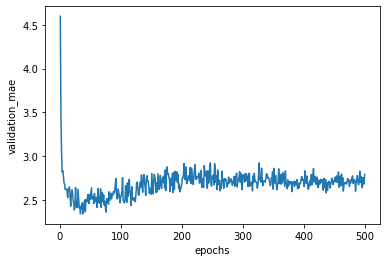

In [41]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(avg_mae_history)+1),avg_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation_mae')
plt.show()


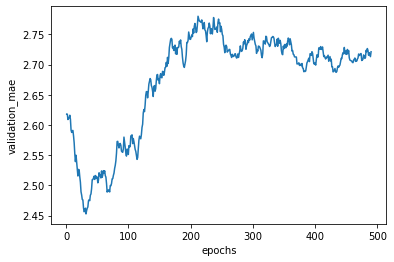

In [42]:
# 곡선의 다른 부분과 스케일이 많이 다른 10개 데이터 제외
# 부드러운 곡선을 얻기위해서 지수 이동평균 적용
def smooth_curv(points,factor = 0.9):
    smoothed_pt =[]
    for pt in points:
        if smoothed_pt:
            prev = smoothed_pt[-1]
            smoothed_pt.append(prev*factor+pt*(1-factor))
        else:
            smoothed_pt.append(pt)
    return smoothed_pt
sm_mae_hist = smooth_curv(avg_mae_history[10:])
plt.plot(range(1,len(sm_mae_hist)+1),sm_mae_hist)
plt.xlabel('epochs')
plt.ylabel('validation_mae')
plt.show()

In [43]:
# 80번째 에폭 이후 val_mae 증가 => 과대 적합 시작
model = build_model()
model.fit(train_data,train_targets,epochs=80,batch_size = 16,verbose = 1)
test_mse_sc,test_mae_sc = model.evaluate(test_data,test_targets)

Epoch 1/80
26/26 [==============================] - 0s 1ms/step - loss: 492.2516 - mae: 20.0940
Epoch 2/80
26/26 [==============================] - 0s 883us/step - loss: 306.7795 - mae: 15.1035
Epoch 3/80
26/26 [==============================] - 0s 1ms/step - loss: 136.9913 - mae: 9.3945
Epoch 4/80
26/26 [==============================] - 0s 893us/step - loss: 58.7752 - mae: 5.8177
Epoch 5/80
26/26 [==============================] - 0s 971us/step - loss: 35.3134 - mae: 4.2201
Epoch 6/80
26/26 [==============================] - 0s 1ms/step - loss: 25.7086 - mae: 3.5432
Epoch 7/80
26/26 [==============================] - 0s 1ms/step - loss: 20.9300 - mae: 3.2067
Epoch 8/80
26/26 [==============================] - 0s 882us/step - loss: 17.8924 - mae: 2.9456
Epoch 9/80
26/26 [==============================] - 0s 1ms/step - loss: 16.1443 - mae: 2.7550
Epoch 10/80
26/26 [==============================] - 0s 989us/step - loss: 14.6239 - mae: 2.6609
Epoch 11/80
26/26 [=========================